Non-negative least squares
--------

### Introduction

In mathematical optimization, the problem of non-negative least squares (NNLS) is a type of constrained least squares problem where the coefficients are not allowed to become negative. It is very helpful in practice because non-negativity constraints occur naturally in diverse fields. As pointed out in [[1]](#refer-1), non-negativity constraints appears in acoustics, genomics, astronomical imaging, hyperspectral imaging, proteomics, and so on. Here we provide a typical examples:

> When processing geodetic data, knowledge on an appropriate covariance matrix of observations is a prerequisite for sub-consequent statistical analysis. The unknown covariance components are to be estimated to properly weight the contribution of different data sets to the final estimates. Non-negativity constraints can be used when estimating the variance components; it is well known that the variances are to be estimated as non-negative numbers [[3]](#refer-3). 

In this examples, it makes sense to respect the non-negativity so as to avoid physically absurd and unpredictable results.

Due to importance of non-negativity, we turn to give a mathematical formulation for non-negative least squares. Suppose we collect $n$ independent observations for a response variable and $p$ explanatory variables, say $y \in R^n$ and $X \in R^{n\times p}$. Let $\epsilon_1, \ldots, \epsilon_n$ be i.i.d zero-mean random noises and $\epsilon = (\epsilon_1, \ldots, \epsilon_n)$, the linear model has a form $y=X \beta +\epsilon$. The non-negative least-squares (NNLS) estimator is given by:

$$ \hat{\beta} \leftarrow \arg\min_{\beta}\| y - X \beta \|^2_2 \;\; \textup{s.t.} \;\; \beta_i \geq 0 \;\; \textup{(for $i = 1, \ldots, p$)}.$$

Another equivalent formulation can be:

$$ \tilde{\beta} \leftarrow \arg\min_{\beta}\| y - X |\beta| \|^2_2,$$

where $|\cdot|$ is a element-wise absolute operator, and $|\tilde{\beta}|$ is the solution of NNLS. 


Interestingly, it is reported that the solution of NNLS is sparse [[1]](#refer-1) when $X$ satisfies certain properties. However, the NNLS cannot exactly control the sparsity of the solution. For instance, although user is interested in a $s$-sparse NNLS estimator, the NNLS may just return a $s'$-sparse solution where $s \neq s'$. We exemplify this via a synthetic dataset. In this dataset, $X$ is drawn from a multivariate gaussian distribution $N(\textbf{0}, \Sigma)$ where $\Sigma_{ij} = 0.8^{|i-j|}$ and $\beta$ is a sparse vector whose non-zero elements are equiv-spaced in $0, \ldots, 299$ with values 10. 
The noises come from the standard normal distribution. The code for generating this dataset is presented below. 

In [84]:
import numpy as np
np.random.seed(123)
num, p = 100, 300
rho = 0.8
k = 5
X = np.random.multivariate_normal(mean=np.zeros(p), 
                                  cov=np.power(rho, np.abs(np.arange(p) - np.arange(p).reshape(p, 1))), 
                                  size=num)

beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [10 for _ in range(k)]
y = X @ beta + np.random.normal(0, 1, num)

The `LinearRegression` in `sklearn.linear_model` can fit standard the NNLS:

In [85]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(positive=True, fit_intercept=False)
lr.fit(X, y)

LinearRegression(fit_intercept=False, positive=True)

Then, we plot the estimated regression coefficient. For comparison, we also plot the true regression coefficient below.   

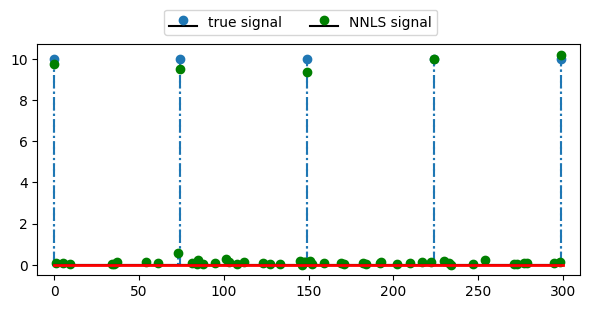

In [86]:
import matplotlib.pyplot as plt
(inx_true,) =  beta.nonzero()
(inx_est,) =  lr.coef_.nonzero()
plt.figure(figsize=(7, 3))
plt.stem(inx_true, beta[inx_true], markerfmt='o', basefmt='k-', linefmt="-.", label="true signal")
plt.stem(inx_est, lr.coef_[inx_est], markerfmt='g', basefmt='k-', linefmt=":", label="NNLS signal")
plt.plot([0, p], [0, 0], 'r-', lw=2)
plt.xlim(-10, p+10)
plt.legend(loc='best', bbox_to_anchor=(0.75, 1.18), ncol=2)

From the above figure, we can see the NNLS estimator can identify the true signal but it also incorrectly selects many ineffective variables. Thus, the NNLS is not suitable for learning the exact sparse non-negative regression coefficients. 

Fortunately, with `skscope`, we can exactly control the sparsity of NNLS.

### Sparse NNLS

Next, we describe the formulation of $s$-sparse NNLS:

$$ \tilde{\beta} \leftarrow \arg\min_{\beta}\| y - X |\beta| \|^2_2, \;\; \textup{s.t.} \;\; \|\beta\|_0 \leq s,$$

then $|\tilde{\beta}|$ is the solution of $s$-sparse NNLS. 

With `skscope`, a few line of code can solve the sparse NNLS estimator described above. 

In [87]:
import jax.numpy as jnp
from scope import ScopeSolver

def nnls(params):
    return jnp.mean((y - X @ jnp.abs(params))**2)

solver = ScopeSolver(p, sparsity=k)
params = np.abs(solver.solve(nnls))

Again, we plot the estimated coefficient returned by `skscope` and compare with the true one. From the below figure, we notice that the sparse NNLS exactly select the true signal and the estimated coefficients are very closed to the true. 

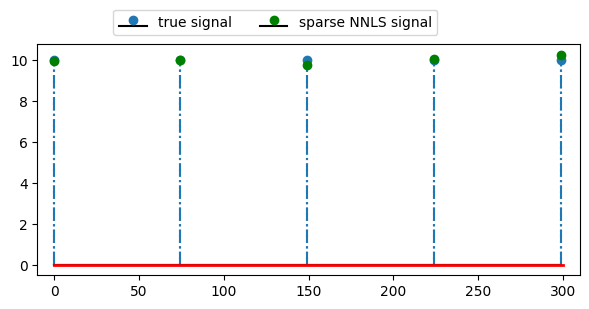

In [88]:
(inx_est,) =  params.nonzero()
plt.figure(figsize=(7, 3))
plt.stem(inx_true, beta[inx_true], markerfmt='o', basefmt='k-', linefmt="-.", label="true signal")
plt.stem(inx_est, params[inx_est], markerfmt='g', basefmt='k-', linefmt=":", label="sparse NNLS signal")
plt.plot([0, p], [0, 0], 'r-', lw=2)
plt.xlim(-10, p+10)
plt.legend(loc='best', bbox_to_anchor=(0.75, 1.18), ncol=2)

We also quantitatively compare the estimation error NNLS and the sparse NNLS in terms of $\ell_2$-norm: 

In [89]:
print('Square Error of sparse NNLS: ', np.sum((params-beta)**2).round(3))
print('Square Error of NNLS: ', np.sum((lr.coef_- beta)**2).round(3))

Square Error of sparse NNLS:  0.119
Square Error of NNLS:  1.695


From the above result, we can conclude the sparse NNLS gives a more accurate estimator. 

### Reference

<div id="refer-1"></div>

- [1] Martin Slawski. Matthias Hein. "Non-negative least squares for high-dimensional linear models: Consistency and sparse recovery without regularization." Electron. J. Statist. 7 3004 - 3056, 2013. https://doi.org/10.1214/13-EJS868

<div id="refer-2"></div>

- [2] Amiri-Simkooei, A.R. Non-negative least-squares variance component estimation with application to GPS time series. J Geod 90, 451–466 (2016). https://doi.org/10.1007/s00190-016-0886-9